In [1]:
#https://youtu.be/6S2v7G-OupA
"""
@author: Sreenivas Bhattiprolu

Shows errors on Tensorflow 1.4 and Keras 2.0.8

Works fine in Tensorflow: 2.2.0
    Keras: 2.4.3

dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns


Start date is:  2020-01-02 00:00:00
End date is:  2024-12-31 00:00:00


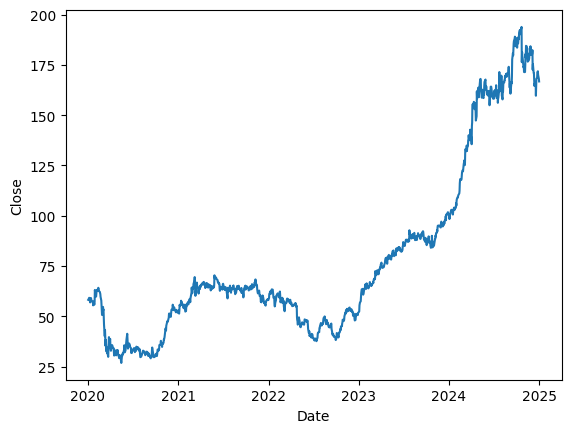

In [51]:

# Load the dataset and skip the first two rows
dataframe = pd.read_csv('GE.csv', skiprows=2)
dataframe = dataframe.rename(columns={"Unnamed: 1": "Close"})

df = dataframe[['Date', 'Close']]


#df['Date'] = pd.to_datetime(df['Date'])
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])

sns.lineplot(x=df['Date'], y=df['Close'])

print("Start date is: ", df['Date'].min())
print("End date is: ", df['Date'].max())

#Change train data from Mid 2017 to 2019.... seems to be a jump early 2017
train, test = df.loc[df['Date'] <= pd.to_datetime('2023-12-31')], df.loc[df['Date'] > pd.to_datetime('2023-12-31')]

#train, test = df.loc[df['Date'] <= '2003-12-31'], df.loc[df['Date'] > '2003-12-31']


In [54]:
print(train.columns)

Index(['Date', 'Close'], dtype='object')


In [55]:
print(train.head())

                  Date      Close
0  2020-01-02 00:00:00  58.161148
1  2020-01-03 00:00:00  58.356167
2  2020-01-06 00:00:00  59.184959
3  2020-01-07 00:00:00  58.746178
4  2020-01-08 00:00:00  58.209915


In [60]:
# Check the shape of the DataFrame
print(test.shape)

(252, 2)


In [62]:
#Convert pandas dataframe to numpy array
#dataset = dataframe.values
#dataset = dataset.astype('float32') #COnvert values to float

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
#scaler = MinMaxScaler() #Also try QuantileTransformer
# Normalize the 'Close' column
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])  # Fit the scaler on the training data

# Transform the 'Close' column in both training and test sets
train.loc[:, 'Close'] = scaler.transform(train[['Close']])  # Use .loc to avoid warnings
test.loc[:, 'Close'] = scaler.transform(test[['Close']])    # Use .loc to avoid warnings

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

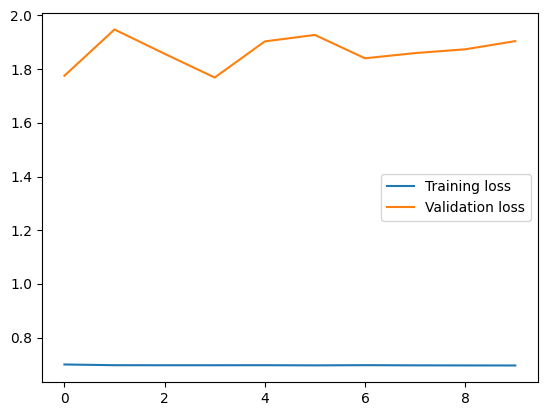

In [66]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

seq_size = 30  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequences(test[['Close']], test['Close'], seq_size)


# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
# seq_size = trainX.shape[1]

# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(64, activation='relu', return_sequences=False))
# model.add(RepeatVector(trainX.shape[1]))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(trainX.shape[2])))

# model.compile(optimizer='adam', loss='mse')
# model.summary()

#Try another model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#model.evaluate(testX, testY)



31/31 [==============================] - 1s 30ms/step


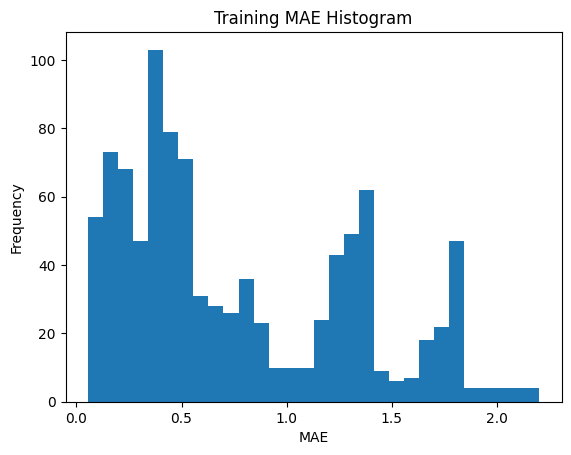

7/7 [==============================] - 0s 32ms/step


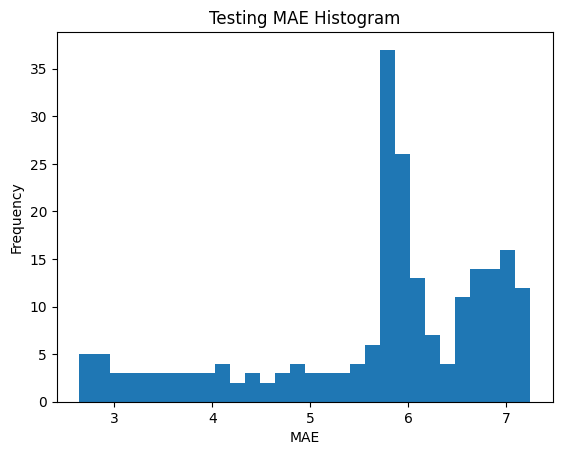

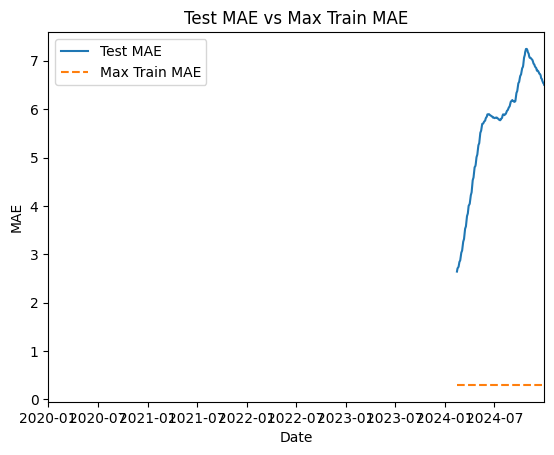

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Anomaly is where reconstruction error is large.
# We can define this value beyond which we call anomaly.
# Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)

# Plot histogram of training MAE
plt.hist(trainMAE, bins=30)
plt.title('Training MAE Histogram')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.show()

max_trainMAE = 0.3  # or define 90% value of max as threshold.

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)

# Plot histogram of testing MAE
plt.hist(testMAE, bins=30)
plt.title('Testing MAE Histogram')
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.show()

# Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

# Plot testMAE vs max_trainMAE using Matplotlib
plt.plot(anomaly_df['Date'], anomaly_df['testMAE'], label='Test MAE')
plt.plot(anomaly_df['Date'], anomaly_df['max_trainMAE'], label='Max Train MAE', linestyle='--')

# Set the x-axis limit to start from 2020
plt.xlim(pd.Timestamp('2020-01-01'), anomaly_df['Date'].max())

# Add labels and title
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('Test MAE vs Max Train MAE')
plt.legend()

# Show the plot
plt.show()

# Identify anomalies
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]


<Axes: xlabel='Date'>

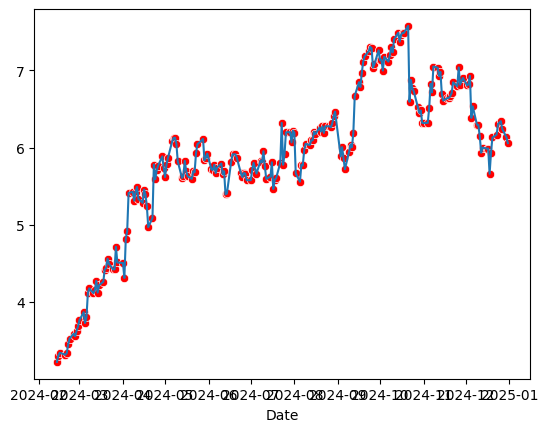

In [77]:
#Plot anomalies
#sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close']))
#sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), color='r')

# Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df[['Close']]).flatten())
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies[['Close']]).flatten(), color='r')